# Unraveling Cain's Jawbone: Narrative Detection using Graph Clustering

Cain's Jawbone, a literary puzzle book published in 1934 under the author's pseudonym "Torquemada", presents an intriguing murder mystery that has captivated readers for decades. The challenge lies in rearranging the book's randomized 100 pages to unveil the correct sequence of events and solve the crime. This intricate puzzle has been successfully cracked by only three individuals to date, highlighting its complexity and allure.

Our project sets out to apply graph algorithms to Cain's Jawbone in an attempt to shed more light on the puzzle or potentially solve it. One of the main challenges lies in finding the correct reading sequence of the 100 pages. Initially we considered approaching this problem by finding a sequence of the 100 pages that maximizes similarity between them. However, with approximately $100! \approx 10^{158}$ possible permutations, this approach becomes computationally infeasable. Moreover, focusing solely on similarity between pages may not guarantee the correct sequence, as multiple narratives might follow one another without necessarily being similar.

One avenue we explored to remedy this was the application of a graph neural network (GNN) trained on actual books to retrieve a reading sequence for Cain's Jawbone. Although inspired by existing works [Attention, Learn to Solve Routing Problems!](https://arxiv.org/abs/1803.08475) and [Learning the Travelling Salesperson Problem Requires Rethinking Generalization](https://arxiv.org/abs/2006.07054), which address the traveling salesperson problem using GNNs and reinforcement learning, this approach proved quite complex and too ambitious for the scope of this project. Our experimental efforts can be found within our notebook [`GNN.ipynb` on our GitHub](https://github.com/maxstolly/Graph-Algorithms-Project/blob/main/GNN.ipynb).

Given the complexity of finding a reading sequence, we shifted our focus to a more feasible task: identifying the six murder victims and their six murderers. The puzzle-solving community theorizes that six distinct narratives surround each murder within the book. To accomplish this, we employed spectral clustering and Louvain community detection algorithms to identify groups of pages corresponding to these narratives.

By employing these graph algorithms, we hope to gain deeper insights into Cain's Jawbone and contribute to the ongoing fascination surrounding this timeless literary puzzle.

## Methodology

In order to use these graph algorithms on our book we first need to convert it into a graph. Since we do not know the actual ordering of the pages we can consider a fully connected graph, where each node represents a page, with the edges weighted by how similar two pages are.

#### Data Preparation

Before constructing the graph, we perform essential and standard routines in natural language processing to clean and standardize the text. The preprocessing steps include:
- Tokenization of the text into individual words.
- Removing special characters, punctuation, and any non-alphanumeric symbols.
- Lemmatization of the words so that they are in their standard form.
- Removing stop words, i.e. common words such as "the", "is" and "and", that are frequently used but add little contextual value.


In [1]:
from tqdm import trange

from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

import matplotlib as mpl
from matplotlib import pyplot as plt

from netgraph import Graph
import networkx as nx
import numpy as np

from nltk import word_tokenize, pos_tag, download
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# download relevant nltk datasets
datasets = ["wordnet", "omw-1.4", "punkt", "averaged_perceptron_tagger", "stopwords"]
for dataset in datasets:
    download(dataset)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
stop_words = set(stopwords.words("english"))

def to_wordnet(tag: str) -> str | None:
    """Converts between position tags and wordnet tags for lemmatization"""
    match tag[0]:
        case "J":
            return wordnet.ADJ
        case "R":
            return wordnet.ADV
        case "N":
            return wordnet.NOUN
        case "V":
            return wordnet.VERB
        case _:
            return None


def preprocess(text: str) -> str:
    """Tokenizes and lemmatizes the text"""
    tokens = [token for token in word_tokenize(text.lower())]
    cleaned = [token for token in tokens if len(token) > 1 and token[0].isalnum() and token[-1].isalnum()]
    tagged = [(word, to_wordnet(tag)) for word, tag in pos_tag(cleaned) if len(word) > 1]
    lemmatizer = WordNetLemmatizer()
    lemmatized = [
        lemmatizer.lemmatize(word, pos=tag) for (word, tag) in tagged if tag is not None
    ]
    words = [word for word in lemmatized if word not in stop_words]
    return " ".join(words)

### Graph Construction

The book can be represented as a fully connected graph, with each page as a node and the edges weighted by how similar the two connected pages are.

To quantify this similarity, we vectorize the pages, which involves calculating the word frequencies on each page and representing them as vectors. By doing so, we create a numerical representation of the book's content.

Now we can use the cosine similarity metric, denoted as $S_C(x, y) = \frac{\langle x, y \rangle}{\|x\| \|y\|}$, where $x$ and $y$ are the vectorized representations of the respective pages. Cosine similarity measures the cosine of the angle between two vectors, which ranges from -1 to 1. However, since our vectors consist of positive frequencies, the cosine similarity will lie within the interval [0, 1]. This similarity score provides insight into how closely related two pages are in terms of their word usage.

In [3]:
# load Cain's Jawbone book
with open("books/Cain's Jawbone.txt", "r", encoding="utf-8") as book:
    pages = book.read().split("\n\n")

data = [preprocess(page) for page in pages]

In [4]:
# vectorize tokens to frequencies
vectorizer = TfidfVectorizer(use_idf=False)
freqs = vectorizer.fit_transform(data)

# calculate cosine similarities between pages
num_pages = len(data)
weights = np.zeros((num_pages, num_pages))
for i, j in np.ndindex(weights.shape):
    weights[i, j] = cosine_similarity(freqs.getrow(i), freqs.getrow(j)).flatten()[0]

# generate fully connected, weighted graph
graph = nx.complete_graph(num_pages)
for i, j in graph.edges:
    graph.edges[i, j]["weight"] = weights[i, j]

c:\Users\maxst\Repos\Graph-Algorithms-Project\.venv\Lib\site-packages\netgraph\_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


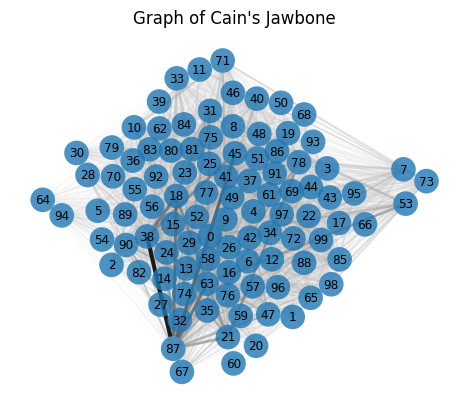

In [5]:
stats = np.array([graph.edges[edge]["weight"] for edge in graph.edges])

edge_dict = {
    (i, j): graph.edges[(i, j)]["weight"] / stats.max() for (i, j) in graph.edges
}

Graph(
    graph,
    node_layout="spring",
    node_layout_kwargs=dict(edge_weights=edge_dict),
    node_color="C0",
    node_size=3,
    node_alpha=0.8,
    node_edge_width=0,
    edge_alpha=edge_dict,
    edge_width=edge_dict,
    node_labels=True,
)
plt.title("Graph of Cain's Jawbone")
plt.show()

Below you can see the distribution of the weights in the graph:

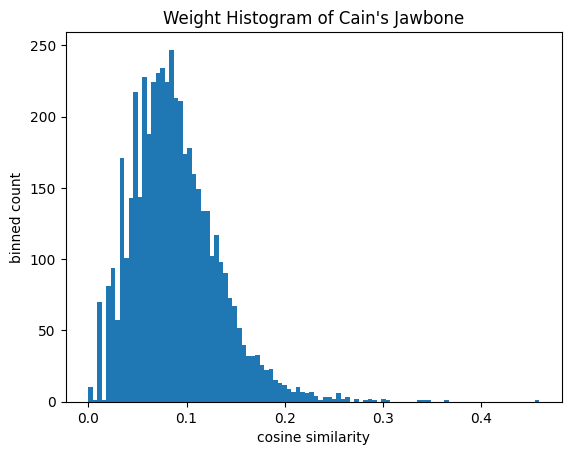

minimum 0.000
average 0.089 +- 0.0439
maximum 0.459


In [6]:
plt.hist(stats, bins=100)
plt.xlabel("cosine similarity")
plt.ylabel("binned count")
plt.title("Weight Histogram of Cain's Jawbone")
plt.show()

print(f"minimum {stats.min():5.3f}")
print(f"average {stats.mean():5.3f} +- {stats.std():5.3}")
print(f"maximum {stats.max():5.3f}")

### Spectral Clustering

Spectral clustering is a powerful technique for partitioning data points based on the Laplacian matrix. It arises as a relaxation to the graph cut problem, where one tries to minimize the number of cuts, or rather the summed value of the cuts, needed to separate the graph into the desired number of partitions.

We implemented spectral clustering using the normalized Laplacian approach described in [A Tutorial on Spectral Clustering](https://arxiv.org/abs/0711.0189). The algorithm takes a graph $G = (V, E)$ and the number of clusters $k$ as input and consists of the following steps:

1. Compute the normalized graph Laplacian $L = I - D^{-1/2} W D^{-1/2}$, where $I$ is the identiy, $D$ the diagonal degree and $W$ the weight matrix of the graph.
1. Compute the eigenvectors $u_1, \dots, u_k$ of $L$ corresponding to the $k$ smallest eigenvalues.
1. Construct the matrix $U \in \mathbb{R}^{|V| \times k}$ containing these eigenvectors as columns.
1. Normalize the rows of $U$ to norm 1.
2. Cluster the the rows of $U$ using [k-means clustering from scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) into clusters $C_1, \dots, C_k$. Alternatively one could also try to minimize $x^\top L x$ with $\|x\|=1$ using for example Reileigh quotients.
3. Output clusters $A_1, \dots, A_k$ with with $A_{i} = \{j \ | \ y_{j} \in C_{j}\}$, where $y_{j}$ is the $j$'th row vector of the matrix $U$.

The resulting partition obtained from the spectral clustering algorithm represents different clusters within the graph. We consider each cluster as a potential narrative within the book Cain's Jawbone.

In [7]:
def spectral_clustering(
    graph: nx.Graph, num_clusters: int, weight: str = "weight", seed: int | None = None
) -> list[set[int]]:
    # compute normalized graph laplacian
    laplacian = nx.normalized_laplacian_matrix(graph, weight=weight).todense()

    # compute first `num_cluster` eigenvectors
    eigenvecs = np.linalg.eigh(laplacian)[1][:, :num_clusters]

    # normalize rows of eigenvector matrix
    norms = np.linalg.norm(eigenvecs, ord=2, axis=1)
    eigenvecs = np.array([row / norms for row in eigenvecs.T]).T

    # cluster the eigenvectors using k-means
    kmeans = KMeans(num_clusters, random_state=seed, n_init="auto").fit(eigenvecs)

    # output corresponding node clusters
    return [
        set([node for node, label in enumerate(kmeans.labels_) if label == i])
        for i in range(num_clusters)
    ]

### Louvain Algorithm

In order to compare the results of the spectral clustering we will also use the Louvain algorithm. The Louvain algorithm is a community detection algorithm. It was proven to be effective in detecting cohesive clusters within complex networks. In our implementation, we used [`louvain_communities` function provided by the NetworkX library](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html). This function iteratively optimizes the graph partitioning by maximizing the modularity measure, which is a measure of the quality of the clustering. For more mathematical information see [Fast unfolding of communities in large networks](https://arxiv.org/abs/0803.0476).

Unlike spectral clustering the Louvain algorithm does not take the number of desired clusters as input but rather finds its own number of clusters through optimizing modularity. So in order to find our 6 narratives we have to tweak the resolution parameter to nudge the algorithm towards our desired number of clusters. Since there is some randomness involved in the algorithm we show the statistics of the number of found clusters from 100 runs below.

In [8]:
resolution = 1.05

runs = []
for seed in range(100):
    communities = nx.community.louvain_communities(graph, resolution=resolution, seed=seed)
    runs.append(len(communities))
runs = np.array(runs)

print("number of communities detected by the Louvain algorithm")
print(f"minimum {runs.min()}")
print(f"average {runs.mean():.2f} +- {runs.std():.2f}")
print(f"maximum {runs.max()}")

number of communities detected by the Louvain algorithm
minimum 5
average 5.88 +- 0.64
maximum 7


## Comparison

To compare the effectiveness of the two clustering algorithms, we can utilize two distinct approaches: quantitative analysis and qualitative analysis. Given the complexity and difficulty of the book's content, conducting a full-fledged qualitative analysis using domain knowledge becomes impractical. Instead, we opted for a quick examination of the best clusters produced by the two algorithms to observe any discernible differences.

For a quantitative approach to gauge the "goodness" of the clusters generated by each algorithm, we need a suitable measure. One such measure is the concept of coherence. Coherence, in the context of topic modeling, refers to the thematic consistency and meaningfulness of the topics. Coherence is a measure that evaluates the relatedness and coherence of words within clusters. It helps determine if the clusters reflect cohesive narratives or themes present in the dataset. See [Exploring the Space of Topic Coherence Measures](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) for more mathematical details and how to apply it.

We ran each algorithm 100 times to account for their inherent randomness of the clustering. The statistics and histograms can be seen below.

In [9]:
texts = [page.split() for page in data]
book_dictionary = Dictionary(vectorizer.inverse_transform(freqs))

def coherence(groups: list[set[int]]) -> float:
    """Returns coherence measure for given groupings"""

    topics = []
    for group in groups:
        words = set()
        for node in group:
            words.update(data[node].split())
        topics.append(list(words))

    model = CoherenceModel(
        topics=topics,
        texts=texts,
        dictionary=book_dictionary,
        coherence="c_v",
    )

    return model.get_coherence()

In [10]:
resolution = 1.05
num_clusters = 6
num_runs = 100
min_length = 5
seed_mod = 0

scores_louvain = []
scores_spectral = []
for seed in trange(num_runs):
    groups_louvain = []
    while len(groups_louvain) != num_clusters or np.any(
        [len(group) < min_length for group in groups_louvain]
    ):
        groups_louvain = nx.community.louvain_communities(
            graph, resolution=resolution, seed=seed + seed_mod
        )
        seed_mod += 1
    scores_louvain.append(coherence(groups_louvain))
    if scores_louvain[-1] == max(scores_louvain):
        best_louvain = groups_louvain

    groups_spectral = spectral_clustering(graph, num_clusters, seed=seed)
    scores_spectral.append(coherence(groups_spectral))
    if scores_spectral[-1] == max(scores_spectral):
        best_spectral = groups_spectral

scores_louvain = np.array(scores_louvain)
scores_spectral = np.array(scores_spectral)

100%|██████████| 100/100 [35:05<00:00, 21.05s/it]


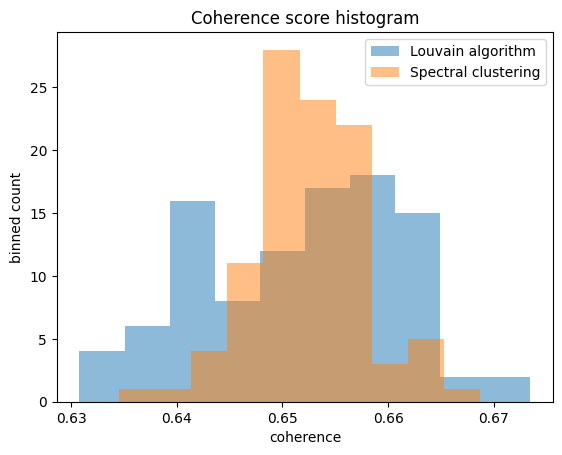

           min    mean +- std     max  
louvain  [0.631, 0.652 +- 0.009, 0.673]
spectral [0.635, 0.653 +- 0.005, 0.669]


In [11]:
bins = 10
plt.hist(scores_louvain, bins=bins, alpha=0.5, label="Louvain algorithm")
plt.hist(scores_spectral, bins=bins, alpha=0.5, label="Spectral clustering")
plt.xlabel("coherence")
plt.ylabel("binned count")
plt.title("Coherence score histogram")
plt.legend()
plt.show()

print("           min    mean +- std     max  ")
print(f"louvain  [{scores_louvain.min():.3f}, {scores_louvain.mean():.3f} +- {scores_louvain.std():.3f}, {scores_louvain.max():.3f}]")
print(f"spectral [{scores_spectral.min():.3f}, {scores_spectral.mean():.3f} +- {scores_spectral.std():.3f}, {scores_spectral.max():.3f}]")

## Results

The application of spectral clustering and the Louvain algorithm allowed us to identify cohesive clusters of the nodes within the constructed graph. These clusters (possibly) correspond to the distinct narrative threads in Cain's Jawbone and if we continue with trying to recover a reading sequence this helped us reduce the seach space of possible permutations from $100! \approx 10^{158}$ to the number of permutations within each cluster, roughly $10^{23}$, which is an improvement of 135 orders of magnitude!

In [12]:
permutations = np.math.factorial(num_clusters) * np.sum(list(map(np.math.factorial, map(len, best_spectral))))
print(f"number of permutations: {permutations:.2e}")

number of permutations: 1.86e+25


Below the two clusterings are plotted.

In [13]:
def plot_groups(
    graph: nx.Graph, groups: list[set[int]], title: str | None = None
) -> None:
    """Plot the communities of a graph."""
    groups_dict = {
        node: i for (i, group) in enumerate(groups) for node in group
    }
    colors = mpl.colormaps["tab10"].colors[: len(groups)]
    node_color = {node: colors[i] for node, i in groups_dict.items()}
    max_weight = np.array([graph.edges[edge]["weight"] for edge in graph.edges]).max()
    edge_dict = {(i, j): graph.edges[(i, j)]["weight"] / max_weight for (i, j) in graph.edges}

    Graph(
        graph,
        node_color=node_color,
        node_edge_width=0,
        edge_alpha=edge_dict,
        edge_width=edge_dict,
        node_layout="community",
        node_layout_kwargs=dict(node_to_community=groups_dict),
        node_labels=True,
    )
    if title is not None:
        plt.title(title)
    plt.show()

c:\Users\maxst\Repos\Graph-Algorithms-Project\.venv\Lib\site-packages\netgraph\_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


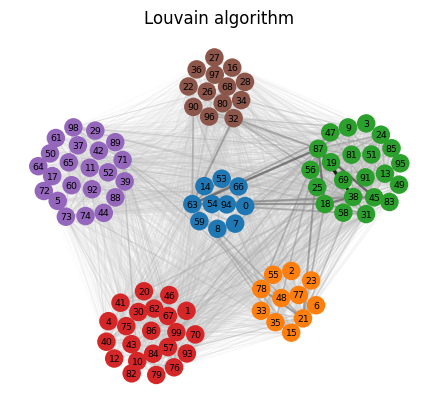

c:\Users\maxst\Repos\Graph-Algorithms-Project\.venv\Lib\site-packages\netgraph\_node_layout.py:1023: RuntimeWarning: invalid value encountered in divide
  directions = deltas / magnitudes[:, np.newaxis]


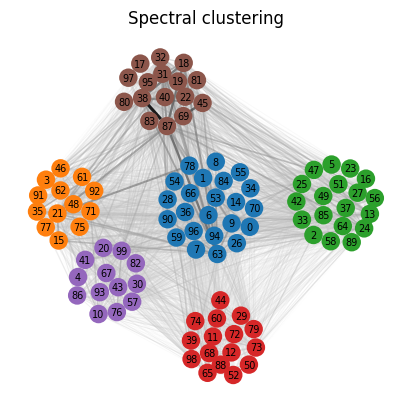

In [14]:
plot_groups(graph, best_louvain, title="Louvain algorithm")
plot_groups(graph, best_spectral, title="Spectral clustering")

## Sources

Our GitHub repository: https://github.com/maxstolly/Graph-Algorithms-Project/

- [Fast unfolding of communities in large networks](https://arxiv.org/abs/0803.0476)
- [From Louvain to Leiden: guaranteeing well-connected communities](https://arxiv.org/abs/1810.08473)
- [A Tutorial on Spectral Clustering](https://arxiv.org/abs/0711.0189)
- [On Spectral Clustering: Analysis and an Algorithm](https://proceedings.neurips.cc/paper/2001/file/801272ee79cfde7fa5960571fee36b9b-Paper.pdf)
- [A Gentle Introduction to Graph Neural Networks](https://distill.pub/2021/gnn-intro/)
- [A Gentle Introduction to Deep Learning for Graphs](https://arxiv.org/abs/1912.12693)
- [Attention, Learn to Solve Routing Problems!](https://arxiv.org/abs/1803.08475)
- [Learning the Travelling Salesperson Problem Requires Rethinking Generalization](https://arxiv.org/abs/2006.07054)